# Elementos de PLN, o El Hacedor 2.0

Siguiendo nuestra lección anterior, optimizaremos nuestro modelo de red neuronal para crear nombres. Ahora, lo haremos en el estilo del *paper* [Bengio et. al, 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from pathlib import Path

In [2]:
path = Path('data/')
if not path.is_dir():
  path.mkdir(parents=True, exist_ok=True)

with open(path / 'nombres.txt', 'wb') as f:
  request = requests.get('https://github.com/DanteNoguez/CalculusRatiocinator/raw/main/data/nombres.txt')
  f.write(request.content)

In [3]:
nombres = open('data/nombres.txt', 'r').read().splitlines()
nombres[:8]

['maria', 'rosa', 'jose', 'carmen', 'ana', 'juana', 'antonio', 'elena']

In [4]:
len(nombres)

21029

In [43]:
V = sorted(set(''.join(nombres)))
paf = {p:f+1 for f, p in enumerate(V)}
paf['.'] = 0
fap = {f:p for p,f in paf.items()}
print(fap)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Un modelo neuronal probabilístico de lenguaje

Primero, comenzaremos dividiendo nuestros datos en «bloques». Por ejemplo, en nuestro modelo de bigramas, el bloque contenía un solo carácter, puesto que realizábamos la predicción a partir de una letra; pero podemos aumentar el «contexto» de nuestras predicciones para involucrar más letras al momento de predecir la siguiente. Veamos, por ejemplo, cómo luciría nuestro tratamiento de los datos si hiciéramos bloques de tres caracteres para predecir el siguiente:

In [19]:
def construir_dataset(nombres):
  block_size = 3 # longitud del contexto
  X, Y = [], []
  for n in nombres:
    #print(f'nombre: {n}')
    contexto = [0] * block_size
    for c in n + '.':
      ix = paf[c]
      X.append(contexto)
      Y.append(ix)
      #print(''.join(fap[i] for i in contexto), '----> ', fap[ix])
      contexto = contexto[1:] + [ix]
  
  X = torch.tensor(X) # contexto
  Y = torch.tensor(Y) # objetivo
  return X, Y

```{margin}
“The training set is a sequence $w_1 · · · w_T$ of words $w_t \in V$, where the vocabulary $V$ is a large but finite set.”
```

In [18]:
construir_dataset(nombres[:3])

nombre: maria
... ---->  m
..m ---->  a
.ma ---->  r
mar ---->  i
ari ---->  a
ria ---->  .
nombre: rosa
... ---->  r
..r ---->  o
.ro ---->  s
ros ---->  a
osa ---->  .
nombre: jose
... ---->  j
..j ---->  o
.jo ---->  s
jos ---->  e
ose ---->  .


(tensor([[ 0,  0,  0],
         [ 0,  0, 13],
         [ 0, 13,  1],
         [13,  1, 18],
         [ 1, 18,  9],
         [18,  9,  1],
         [ 0,  0,  0],
         [ 0,  0, 18],
         [ 0, 18, 15],
         [18, 15, 19],
         [15, 19,  1],
         [ 0,  0,  0],
         [ 0,  0, 10],
         [ 0, 10, 15],
         [10, 15, 19],
         [15, 19,  5]]),
 tensor([13,  1, 18,  9,  1,  0, 18, 15, 19,  1,  0, 10, 15, 19,  5,  0]))

Nuestra intuición detrás de esta aproximación es que el lenguaje funciona mejor con contexto: así como el sentido de un concepto se entiende mejor en contexto, también los caracteres se pueden predecir más razonablemente dado un contexto más amplio. 

Similar a como habíamos hecho anteriormente, construimos una matriz `X` para contener el contexto como entrada y un vector `Y` que contiene el objetivo (es decir, carácter) que debe seguir a cada respectivo contexto. Como se puede apreciar, solamente estamos construyendo `X` e `Y` con sus respectivos índices del vocabulario.

Dado que solo tomamos 3 nombres como ejemplo, nuestros datos únicamente contienen 16 contextos o *inputs* y 16 objetivos o *outputs*:

In [21]:
X, Y = construir_dataset(nombres[:3])
X.shape, Y.shape

(torch.Size([16, 3]), torch.Size([16]))

Ahora estamos listos para hacer el *embedding*. Mientras que en el *paper* los datos se incrustan en una tabla de consulta de 30 dimensiones (o *features*) para un vocabulario de 17,000 palabras, nosotros —que únicamente tenemos un vocabulario de 27 caracteres— podemos aproximarnos a la incrustación con algo más pequeño, como una incrustación de dos dimensiones.

In [26]:
C = torch.randn((27, 2)) # tabla de consulta
C

tensor([[ 1.2398,  1.6226],
        [-1.0390, -0.6315],
        [ 1.4867, -2.0639],
        [-0.5019, -0.0847],
        [ 0.3543,  0.0429],
        [ 0.0747,  0.0483],
        [-0.8429, -0.7471],
        [ 1.2111, -0.4298],
        [-0.2744, -0.0716],
        [ 0.8073,  1.4253],
        [ 0.7349, -1.3932],
        [-0.7396, -1.6109],
        [ 1.1352,  1.1073],
        [-1.8026, -1.0121],
        [ 0.2880,  0.6969],
        [-0.9063, -0.2191],
        [-0.2776,  0.0224],
        [-0.0813,  1.3615],
        [ 0.7298,  0.3834],
        [ 0.3386, -0.9600],
        [-0.6149,  0.0942],
        [ 0.8082,  3.5541],
        [-0.5630, -0.5980],
        [ 1.1308,  0.9338],
        [-0.3946,  0.1407],
        [ 0.1347, -1.3152],
        [ 0.2762, -0.8832]])

Como vemos, cada *token* o elemento del volcabulario se incrustará en dos dimensiones, es decir, tendrá dos números asociados. Ahora, tomaremos un atajo que nos permitirá ser más eficientes con la codificación y la primera capa de la red neuronal. Anteriormente, habíamos hecho un *one-hot encoding* para luego pasarlo por una capa `W`; pero, bien visto, estos dos pasos pueden ser omitidos porque consiguen el mismo resultado que la incrustación en nuestra tabla `C`. 

Primero: la codificación *one-hot*, si fuéramos a multiplicarla por `C`, anularía todos los valores de `C` al multiplicarlos por 0 y conservaría una fila correspondiente a la de la multiplicación por 1. Ergo, podemos omitir la multiplicación y hacer una indexación para asociar directamente cada carácter con cada fila que un vector *one-hot* multiplicaría por 1. Dicho esto, podemos concebir a `C` como un equivalente de la capa `W`, puesto que consiste de valores aleatorios que asignan un número a cada carácter y luego pueden optimizarse con propagación hacia atrás.

Dicho esto, la indexación (*embedding*) será bastante simple:

```{margin}
“A mapping $C$ from any element $i$ of $V$ to a real vector $C(i) \in \mathbb{R}^m$. It represents the distributed feature vectors associated with each word in the vocabulary. In practice, C is represented by a $\left|V\right| \times m$ matrix of free parameters”.
```

In [42]:
emb = C[X] # embedding

f'Segunda fila de C: {C[1].numpy()} | Tercer valor del tercer bloque incrustado (es decir, letra a): {emb[2][2].numpy()}'

'Segunda fila de C: [-1.0390474 -0.6314941] | Tercer valor del tercer bloque incrustado (es decir, letra a): [-1.0390474 -0.6314941]'

In [48]:
print('Dimensiones del embedding: ', emb.shape) 
print('Tres bloques del embedding, correspondientes a «..m», «.ma» y «mar»:', emb[1:4])

Dimensiones del embedding:  torch.Size([16, 3, 2])
Tres bloques del embedding, correspondientes a «..m», «.ma» y «mar»: tensor([[[ 1.2398,  1.6226],
         [ 1.2398,  1.6226],
         [-1.8026, -1.0121]],

        [[ 1.2398,  1.6226],
         [-1.8026, -1.0121],
         [-1.0390, -0.6315]],

        [[-1.8026, -1.0121],
         [-1.0390, -0.6315],
         [ 0.7298,  0.3834]]])


Ahora, echemos un vistazo a la arquitectura que deseamos lograr:

```{figure} ../../img/bengio2003.png
---
width: 70%
name: bengio2003
---
Arquitectura neuronal $f\left(i, w_{t-1}, \cdots, w_{t-n+1}\right)=g\left(i, C\left(w_{t-1}\right), \cdots, C\left(w_{t-n+1}\right)\right)$ donde $g$ es la red neuronal y $C(i)$ es el $i$-ésimo vector de cada palabra. En nuestro caso, utilizamos bloques de tres letras (`contexto`, vector `X`) en lugar de palabras ($w$).
```

Como vemos, tenemos casi terminado el inicio y únicamente nos falta concatenar entre sí los bloques del *embedding*, puesto que juntos atravesarán la misma capa de neuronas.
```{margin}
“\[...] $x$ is the word features layer activation vector, which is the concatenation of the input word features from the matrix $C$: $x = C\left(w_{t-1}\right), \left(w_{t-2}\right) \cdots, C\left(w_{t-n+1}\right)$.”
```
Para conseguirlo, podemos utilizar distintos métodos con PyTorch:

In [65]:
metodo1 = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
print(f"""Ahora, en lugar de estar contenidos en bloques de tres filas: 
{emb[0]}
Estarían contenidos en una fila de tres bloques (seis columnas):
{metodo1[0]}""")

Ahora, en lugar de estar contenidos en bloques de tres filas: 
tensor([[1.2398, 1.6226],
        [1.2398, 1.6226],
        [1.2398, 1.6226]])
Estarían contenidos en una fila de tres bloques (seis columnas):
tensor([1.2398, 1.6226, 1.2398, 1.6226, 1.2398, 1.6226])


In [67]:
metodo2 = torch.cat(torch.unbind(emb, 1), 1)
f'Aunque también es equivalente: {metodo2[0]}'

'Aunque también es equivalente: tensor([1.2398, 1.6226, 1.2398, 1.6226, 1.2398, 1.6226])'

Pero el método más eficiente[^1] y simple es `view`. Como primer argumento, colocaremos `-1` para que de esta forma PyTorch infiera el tamaño de la dimensión 0 que debería tener el tensor (sería, pues, equivalente a colocar `emb[0].shape`), y como segundo argumento `6` porque queremos que el tensor tenga las 6 columnas correspondientes a los tres bloques de cada *input*:

In [70]:
x = emb.view(-1, 6)
x[0], x.shape

(tensor([1.2398, 1.6226, 1.2398, 1.6226, 1.2398, 1.6226]), torch.Size([16, 6]))

Ahora ya tenemos lo suficiente para definir más variables:

> “Let $h$ be the number of hidden units[^2], and $m$ the number of features associated with each word. When no direct connections from word features to outputs are desired, the matrix $W$ is set to 0 . The free parameters of the model are the output biases $b$ (with $|V|$ elements), the hidden layer biases $d$ (with $h$ elements), the hidden-to-output weights $U$ (a $|V| \times h$ matrix), the word features to output weights $W$ (a $|V| \times(n-1) m$ matrix), the hidden layer weights $H$ (a $h \times(n-1) m$ matrix), and the word features $C(\mathrm{a}|V| \times m$ matrix $)$: $\theta=(b, d, W, U, H, C)$”.

In [ ]:
import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
Xtr.shape

torch.Size([132473, 3])

In [ ]:
C = torch.randn(27, 10)
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn(200, 27)
b2 = torch.randn(27)
parameters = [C, W1, b2, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11724

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

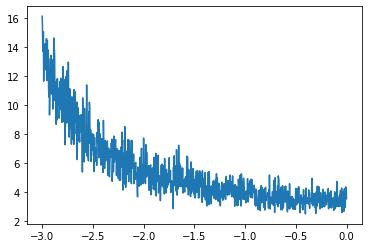

In [ ]:
plt.plot(lri, lossi)

In [ ]:
10**-0.5

0.31622776601683794

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(1000):
  #minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  #forward pass
  emb = C[Xtr][ix]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  #lr = lrs[i]
  lr = -0.031
  for p in parameters:
    p.data += lr * p.grad

  #track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.8074958324432373


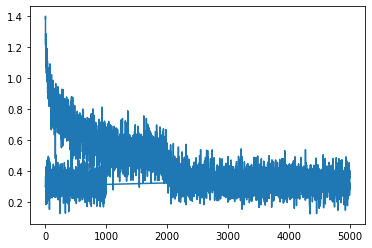

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1043, grad_fn=<NllLossBackward0>)

In [ ]:
block_size = 3
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

usabiano.
reresrabendo.
alla.
selmoriva.
elsoip.
ziga.
pention.
claura.
oru.
frudogia.
antrerio.
nima.
srobent.
bertiquin.
devonia.
sacia.
alida.
vabladis.
capia.
edubgakio.


[^1]: El método `view` es eficiente porque [no requiere de nuevo espacio](http://blog.ezyang.com/2019/05/pytorch-internals/) en la memoria de nuestra computadora, sino que utiliza el mismo tensor para reacomodarlo de manera distinta. Conforme nuestros programas se vuelvan más complejos, debemos procurar eficientar al máximo nuestros recursos computacionales. Para un acercamiento más general al tema, véase el [artículo de Horace He](https://horace.io/brrr_intro.html).

[^2]: En *deep learning*, el término *hidden* («oculto») se utiliza para referirse a componentes de una red neuronal que no son «visibles» ni como entradas ni como salidas de la red. Se trata de entradas o salidas que se procesan internamente por la red neuronal antes de arrojar un resultado final. La *hidden unit*, en ese sentido, se refiere a cada unidad o componente de una capa oculta (*hidden layer*) en la red. Podemos entenderla como sinónimo de «nodo» o «neurona».